Taylor-Goldstein analysis to determine the wavelength of the waves. You need to run the notebook `IW_KE.ipynb` first, because that creates some files that are then used in this

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import gsw
from pytg import TG
import tqdm

# Fjord stratification

Text(0.5, 1.0, 'mean density profile')

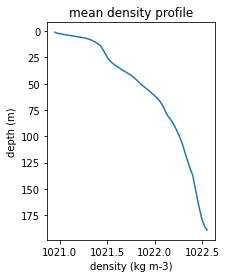

In [2]:
dd = xr.open_dataset("../data/downstream_deep_mooring_2018.nc")
# ctd = xr.open_dataset("../data/combo_sep_2018.nc")
pfl = np.genfromtxt('../data/sep_2018_mean_TS_profile.csv', delimiter=',', skip_header=1)

cdepth = pfl[:, 0]
cSP = pfl[:, 1]
ct = pfl[:, 2]

cp = gsw.p_from_z(-cdepth, dd.lat.values)
cSA = gsw.SA_from_SP(cSP, cdepth, dd.lon.values, dd.lat.values)
cCT = gsw.CT_from_t(cSA, ct, cp)
csig0 = gsw.pot_rho_t_exact(cSA, ct, cp, 0)
N2, p_mid = gsw.Nsquared(cSA, cCT, cp)
Ncpd = np.sqrt(N2)*86400/(np.pi*2)

fig, ax = plt.subplots(figsize=(3, 4))
ax.invert_yaxis()
ax.plot(csig0, cdepth)
ax.set_ylabel("depth (m)")
ax.set_xlabel("density (kg m-3)")
ax.set_title("mean density profile")

# Figure for paper (no velocity)

loop over wavelengths, find maximum mode number with period less than 30 min

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:21<00:00,  1.12it/s]


Text(0.5, 0, 'Wavelength [m]')

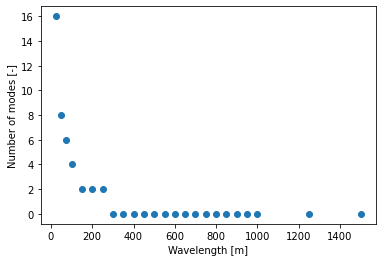

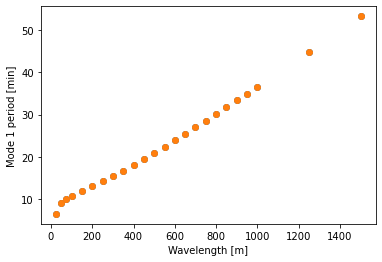

In [3]:
dmax = 180  # Max depth [m]
Krho = 1e-3
Tmax = 15*60
g = 9.81

sig0_ = csig0[cdepth < dmax]
depth_ = cdepth[cdepth < dmax]


b = -g*sig0_/sig0_.mean()  # Buoyancy profile

wvls = np.hstack(([25, 50., 75.], np.arange(100, 1050, 50.), [1250, 1500]))
nmodes = np.zeros((wvls.size))
m1period = np.zeros((wvls.size, 2))


for i in tqdm.tqdm(range(wvls.size)):
    
    k = np.pi*2/wvls[i]
    
    om, _, _, _, _ = TG.vTG(-depth_, 0*b, 0*b, b, k, 0, Krho, Krho, BCv_upper='rigid', BCv_lower='rigid', BCb_upper='constant', BCb_lower='constant')
    T = np.abs(np.pi*2/om.imag)
    nmodes[i] = (T < Tmax).sum()
    m1period[i, 0] = T[0]
    m1period[i, 1] = T[-1]
    
fig, ax = plt.subplots()
ax.plot(wvls, nmodes, 'o')
ax.set_ylabel("Number of modes [-]")
ax.set_xlabel("Wavelength [m]")

fig, ax = plt.subplots()
ax.plot(wvls, m1period/60, 'o')
ax.set_ylabel("Mode 1 period [min]")
ax.set_xlabel("Wavelength [m]")

In [4]:
wb_MN = xr.open_dataarray("../data/MN_band_pass_w.nc")
wb_MD = xr.open_dataarray("../data/MD_band_pass_w.nc")

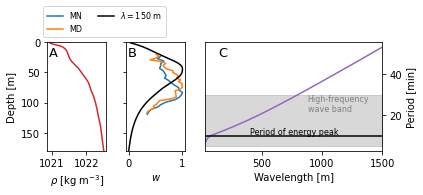

In [5]:
dmax = 180
Krho = 1e-4
time1 = np.datetime64("2018-09-03T07:00")

tslice = slice(time1, time1 + np.timedelta64(3600, 's'))

sig0_ = csig0[cdepth < dmax]
depth_ = cdepth[cdepth < dmax]

b = -g*sig0_/sig0_.mean()

fig, axs = plt.subplots(1, 3, figsize=(6, 2), gridspec_kw={"width_ratios":[1, 1, 3]})
axs[-1].yaxis.tick_right()
axs[-1].yaxis.set_label_position("right")

axs[0].plot(sig0_, depth_, "C3")

wrms = (wb_MN.sel(time=tslice)**2).mean("time")**0.5
imax = np.argmax(np.fabs(wrms.data))
axs[1].plot(wrms/wrms[imax].data, wrms.depth_adcp, label="MN")

wrms = (wb_MD.sel(time=tslice)**2).mean("time")**0.5
imax = np.argmax(np.fabs(wrms.data))
axs[1].plot(wrms/wrms[imax].data, wrms.depth_adcp, label="MD")

wavelength = 150
k = np.pi*2/wavelength
om, wvec, _, uvec, _ = TG.vTG(-depth_, 0*b, 0*b, b, k, 0, Krho, Krho, BCv_upper='rigid', BCv_lower='rigid', BCb_upper='constant', BCb_lower='constant')
wvec = wvec.real
imax = np.argmax(np.fabs(wvec[:, 0]))
axs[1].plot((wvec[:, 0]/wvec[imax, 0]), depth_, "k", label="$\lambda = 150$ m")
        
axs[-1].plot(wvls, m1period[:, 0]/60, "C4")

axs[0].set_xlabel(r"$\rho$ [kg m$^{-3}$]")
axs[1].set_xlabel("$w$")
axs[2].set_xlabel("Wavelength [m]")

axs[0].set_ylabel("Depth [m]")
axs[-1].set_ylabel("Period [min]")

axs[1].legend(loc=(-1.4, 1.05), ncol=2, fontsize=8)

for ax in axs[:-1]:
    ax.set_ylim(180, 0)
    
for ax in axs[1:-1]:
    ax.set_yticklabels([])
    
axs[-1].set_xlim(wvls[0], wvls[-1])

axs[-1].fill_between(axs[-1].get_xlim(), 5, 30, color="gray", alpha=0.3)
axs[-1].axhline(10, color="k")
axs[-1].annotate("Period of energy peak", (400, 11), color="k", fontsize=8)

axs[-1].annotate("High-frequency\nwave band", (880, 22), color="gray", fontsize=8)

# pos = axs[0].get_position()
# fig.text(pos.x0 - 0.07, pos.y1 - 0.03, "A", fontsize=13)
# pos = axs[1].get_position()
# fig.text(pos.x0 - 0.04, pos.y1 - 0.03, "B", fontsize=13)
# pos = axs[2].get_position()
# fig.text(pos.x0 - 0.04, pos.y1 - 0.03, "C", fontsize=13)

fig.align_xlabels(axs)

axs[0].text(0.1, 0.9, "A", fontsize=13, ha='center', va='center', transform=axs[0].transAxes)
axs[1].text(0.1, 0.9, "B", fontsize=13, ha='center', va='center', transform=axs[1].transAxes)
axs[2].text(0.1, 0.9, "C", fontsize=13, ha='center', va='center', transform=axs[2].transAxes)

fig.savefig("../figures/TG.pdf", dpi=300, bbox_inches="tight", pad_inches=0)
fig.savefig("../figures/TG.png", dpi=300, bbox_inches="tight", pad_inches=0)